In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

sns.set(style="darkgrid")
sns.set_palette('hls', 4)

# Help functions

In [2]:
def count_stats(key, arr):
    s = {}
    s['mean'] = arr[key].mean()
    s['median'] = arr[key].median()
    s['range'] = arr[key].max() - arr[key].min()
    s['var'] = arr[key].var()
    s['max'] = arr[key].max()
    s['min'] = arr[key].min()
    s['std'] = arr[key].std()
    return s

In [3]:
def extract_memory_value(memory_str):
    try:
        return float(memory_str.split()[0])
    except (ValueError, IndexError):
        return None

In [4]:
real_resolutions = {
    'PC_A_WIN10_Brave': [2048, 1042],
    'PC_A_WIN10_Chrome': [2048, 1035],
    'PC_A_WIN10_Firefox': [2048, 1037],
    'PC_A_WIN10_Tor': [2400, 1000],
    'PC_A_Ubuntu_Brave': [2490, 1332],
    'PC_A_Ubuntu_Firefox': [2490, 1328],
    'PC_A_Ubuntu_Chrome': [2490, 1328],
    'PC_A_Ubuntu_Tor': [2400, 1000],
    'PC_B_WIN11_Brave': [1536, 735],
    'PC_B_WIN11_Chrome': [1536, 730],
    'PC_B_WIN11_Firefox': [1536, 731],
    'PC_B_WIN11_Tor': [1400, 800],
    'PC_C_MacOS_Brave': [1512, 862],
    'PC_C_MacOS_Chrome': [1512, 858],
    'PC_C_MacOS_Firefox': [1512, 860],
    'PC_C_MacOS_Safari': [1512, 893],
    'PC_C_MacOS_Tor': [1400, 800],
}

def load_df(file_path):
    df = pd.read_csv(file_path)

    df['Attributes'] = df['Attributes'].apply(ast.literal_eval)
    for key in set().union(*(df['Attributes'].dropna().tolist())):
        df[key] = df['Attributes'].apply(lambda x: x.get(key) if isinstance(x, dict) else None)
    
    df['Memory_GB'] = df['Attributes'].apply(lambda x: extract_memory_value(x.get('Memory', '0 GB')))
    
    for key in real_resolutions:
        res = real_resolutions[key]
    
        if key in file_path:
            df['Width Deviation'] = df['Screen Width'] - res[0]
            df['Height Deviation'] = df['Screen Height'] - res[1]
            break
    
    df.drop(columns=['Attributes'], inplace=True)
    
    return df

In [5]:
def get_stats(key):
    stats = {name: count_stats(key, df) for name, df in dataframes.items()}
    stats_df = pd.DataFrame(stats).T
    pd.options.display.float_format = '{:,.2f}'.format

    return stats_df


In [6]:
def create_summarized_df(dataframes):
    columns = ['CPU', 'Memory_GB', 'Width Deviation', 'Height Deviation', 'Name']
    summarized_df = pd.DataFrame()  # Initialize an empty DataFrame

    for name, df in dataframes.items():
        tmp_df = df.copy()
        # Add missing columns with default value 0
        for col in columns[:-1]:
            if col not in tmp_df.columns:
                tmp_df[col] = 0
        tmp_df = tmp_df[columns[:-1]]  # Select the necessary columns
        tmp_df['Name'] = name  # Assign the name to the 'Name' column
        # Ensure all numeric columns are of a consistent type to avoid the warning
        tmp_df[columns[:-1]] = tmp_df[columns[:-1]].apply(pd.to_numeric, errors='coerce').fillna(0)
        summarized_df = pd.concat([summarized_df, tmp_df], ignore_index=True)

    summarized_df = summarized_df.fillna(0)  # Replace any remaining NaN values with 0
    return summarized_df

In [7]:
def create_distribution_plot(df1, df2, df1_title, df2_title, title, x_label, y_label, key):
    df1['Title'] = df1_title
    df2['Title'] = df2_title
    combined = pd.concat([df1, df2])

    counts = combined.groupby([key, 'Title']).size().reset_index(name='Counts')

    df1_counts = counts[counts['Title'] == df1_title].set_index(key)['Counts']
    df2_counts = counts[counts['Title'] == df2_title].set_index(key)['Counts']

    all_cpus = df1_counts.index.union(df2_counts.index)
    df1_counts = df1_counts.reindex(all_cpus, fill_value=0)
    df2_counts = df2_counts.reindex(all_cpus, fill_value=0)

    bar_width = 0.35
    index = np.arange(len(all_cpus))

    fig, ax = plt.subplots(figsize=(10, 6))

    bar1 = ax.bar(index - bar_width/2, df1_counts, bar_width, label=df1_title)
    bar2 = ax.bar(index + bar_width/2, df2_counts, bar_width, label=df2_title)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(all_cpus)
    ax.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def create_comparing_boxplot(attr, title, x_label, y_label):  
    combined_data = pd.concat(
        [df.assign(
            OS=" ".join(key.split()[:3]),  # Keep only "PC A Win10"
            Setting="Strict" if "Strict" in key else "Classic"
        ) for key, df in dataframes.items()],
        ignore_index=True
    )

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='OS', y=attr, hue='Setting', data=combined_data, dodge=True)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='Setting')
    #plt.xticks(rotation=30, ha='right')
    plt.show()

In [9]:
def create_sma_bar_plot(df, key, title, x_label, y_label):
    
    palette = sns.color_palette("hls")
    
    df['5SMA'] = df[key].rolling(window=5).mean()
    df['15SMA'] = df[key].rolling(window=15).mean()
    df['30SMA'] = df[key].rolling(window=30).mean()
    
    plt.figure(figsize=(14, 7))
    
    bar_label = key + " Count"
    plt.bar(range(len(df)), df[key], label=bar_label)
    
    plt.plot(df['5SMA'], label='5 SMA', linewidth=2, color=palette[2])
    plt.plot(df['15SMA'], label='15 SMA', linewidth=2, color=palette[3])
    plt.plot(df['30SMA'], label='30 SMA', linewidth=2, color=palette[4])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
def create_correlation_matrix4(df):
    
    fieldnames = ['CPU', 'Memory_GB', 'Width Deviation', 'Height Deviation']
    df2 = df[fieldnames]
    
    correlation_matrix = df2.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Browser Attributes")
    plt.show()

In [11]:

def create_freq_table(key):
    freq = {
        "PC A Win10 Brave Strict Profile A": pc_a_win10_strict_A[key].value_counts(),
        "PC A Win10 Brave Strict Profile B": pc_a_win10_strict_B[key].value_counts(),
        "PC A Win10 Brave Classic Profile A": pc_a_win10_classic_A[key].value_counts(),
        "PC A Win10 Brave Classic Profile B": pc_a_win10_classic_B[key].value_counts(),
        "PC B Win11 Brave Strict Profile A": pc_b_win11_strict_A[key].value_counts(),
        "PC B Win11 Brave Strict Profile B": pc_b_win11_strict_B[key].value_counts(),
        "PC B Win11 Brave Classic Profile A": pc_b_win11_classic_A[key].value_counts(),
        "PC B Win11 Brave Classic Profile B": pc_b_win11_classic_B[key].value_counts(),
    } 

    freq_df = pd.DataFrame(freq)
    freq_df.fillna(0, inplace=True)
    freq_df = freq_df.astype(int)  # Convert all float values to integer

    freq_df.reset_index(inplace=True)
    freq_df.rename(columns={'index': key}, inplace=True)
    
    df_corrected = pd.DataFrame(freq_df.set_index(key))  # Assuming 'key' is 'Memory_GB' or similar
    df_corrected = df_corrected.reset_index().rename(columns={'index': 'Configuration'})
    df_corrected = df_corrected.set_index(key)
    
    return df_corrected

In [12]:
def safe_string_to_dict(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return {}

In [ ]:
# Add this cell to your notebook
def plot_cross_correlation(df1, df2, key, label1, label2):
    """
    Plots a scatter plot and computes the Pearson correlation coefficient
    between the same key in two datasets.
    """
    x = df1[key].dropna().reset_index(drop=True)
    y = df2[key].dropna().reset_index(drop=True)
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]
    corr = x.corr(y)
    plt.figure(figsize=(7, 5))
    plt.scatter(x, y)
    plt.xlabel(f"{label1} - {key}")
    plt.ylabel(f"{label2} - {key}")
    plt.title(f"Correlation between {label1} and {label2} for '{key}'\nPearson r = {corr:.2f}")
    plt.grid(True)
    plt.show()
    print(f"Pearson correlation coefficient: {corr:.3f}")

# Common statistics

In [13]:
pc_a_win10_strict_A  = load_df("../data/profile_data/PC_A_WIN10_Brave_Strict_ProfileA.csv")
pc_a_win10_strict_B  = load_df("../data/profile_data/PC_A_WIN10_Brave_Strict_ProfileB.csv")
pc_a_win10_classic_A  = load_df("../data/profile_data/PC_A_WIN10_Brave_Classic_ProfileA.csv")
pc_a_win10_classic_B  = load_df("../data/profile_data/PC_A_WIN10_Brave_Classic_ProfileB.csv")
pc_b_win11_strict_A  = load_df("../data/profile_data/PC_B_WIN11_Brave_Strict_ProfileA.csv")
pc_b_win11_strict_B  = load_df("../data/profile_data/PC_B_WIN11_Brave_Strict_ProfileB.csv")
pc_b_win11_classic_A  = load_df("../data/profile_data/PC_B_WIN11_Brave_Classic_ProfileA.csv")
pc_b_win11_classic_B  = load_df("../data/profile_data/PC_B_WIN11_Brave_Classic_ProfileB.csv")

dataframes = {
        "PC A Win10 Brave Strict Profile A": pc_a_win10_strict_A,
        "PC A Win10 Brave Strict Profile B": pc_a_win10_strict_B,
        "PC A Win10 Brave Classic Profile A": pc_a_win10_classic_A,
        "PC A Win10 Brave Classic Profile B": pc_a_win10_classic_B,
        "PC B Win11 Brave Strict Profile A": pc_b_win11_strict_A,
        "PC B Win11 Brave Strict Profile B": pc_b_win11_strict_B,
        "PC B Win11 Brave Classic A": pc_b_win11_classic_A,
        "PC B Win11 Brave Classic B": pc_b_win11_classic_B,
    }

In [14]:
summary_statistics = create_summarized_df(dataframes)
summary_statistics = summary_statistics.groupby('Name').agg(['mean', 'median', 'std', 'min', 'max'])
summary_statistics

CPU                           \
                                           mean median       std min max   
Name                                                                       
PC A Win10 Brave Aggressive Profile A  5.160000    5.0  1.993525   2   8   
PC A Win10 Brave Aggressive Profile B  5.058824    5.0  1.984213   2   8   
PC A Win10 Brave Classic Profile A     3.020202    3.0  0.832746   2   4   
PC A Win10 Brave Classic Profile B     2.932039    3.0  0.866163   2   4   
PC B Win11 Brave Aggressive Profile A  5.030303    5.0  2.067506   2   8   
PC B Win11 Brave Aggressive Profile B  4.962264    5.0  2.046714   2   8   
PC B Win11 Brave Classic A             4.888889    5.0  1.937223   2   8   
PC B Win11 Brave Classic B             5.000000    5.0  1.899432   2   8   

                                      Memory_GB                              \
                                           mean median       std   min  max   
Name                                                                          
PC A Win10 Brave Aggressive Profile A  3.027500    2.0  2.834424  0.25  8.0   
PC A Win10 Brave Aggressive Profile B  2.539216    1.0  2.844516  0.25  8.0   
PC A Win10 Brave Classic Profile A     3.186869    2.0  2.816303  0.50  8.0   
PC A Win10 Brave Classic Profile B     3.548544    2.0  2.929326  0.50  8.0   
PC B Win11 Brave Aggressive Profile A  2.525253    1.0  2.708051  0.25  8.0   
PC B Win11 Brave Aggressive Profile B  2.740566    2.0  2.750741  0.25  8.0   
PC B Win11 Brave Classic A             2.833333    2.0  2.588239  0.50  8.0   
PC B Win11 Brave Classic B             3.596154    2.0  2.932306  0.50  8.0   

                                      Width Deviation                       \
                                                 mean median       std min   
Name                                                                         
PC A Win10 Brave Aggressive Profile A        3.780000    3.0  2.623052   0   
PC A Win10 Brave Aggressive Profile B        4.078431    4.0  2.777870   0   
PC A Win10 Brave Classic Profile A           4.030303    4.0  2.592983   0   
PC A Win10 Brave Classic Profile B           4.087379    4.0  2.646147   0   
PC B Win11 Brave Aggressive Profile A        4.030303    4.0  2.484460   0   
PC B Win11 Brave Aggressive Profile B        4.179245    5.0  2.547818   0   
PC B Win11 Brave Classic A                   4.040404    4.0  2.633843   0   
PC B Win11 Brave Classic B                   4.211538    4.0  2.644540   0   

                                          Height Deviation                   \
                                      max             mean median       std   
Name                                                                          
PC A Win10 Brave Aggressive Profile A   8         4.280000    4.0  2.441559   
PC A Win10 Brave Aggressive Profile B   8         2.833333    3.0  2.068545   
PC A Win10 Brave Classic Profile A      8         3.919192    4.0  2.597789   
PC A Win10 Brave Classic Profile B      8         3.087379    3.0  1.965919   
PC B Win11 Brave Aggressive Profile A   8         3.717172    4.0  2.691788   
PC B Win11 Brave Aggressive Profile B   8         3.688679    3.5  2.477953   
PC B Win11 Brave Classic A              8         4.333333    5.0  2.740475   
PC B Win11 Brave Classic B              8         3.519231    3.0  2.380397   

                                               
                                      min max  
Name                                           
PC A Win10 Brave Aggressive Profile A   0   8  
PC A Win10 Brave Aggressive Profile B   0   7  
PC A Win10 Brave Classic Profile A      0   8  
PC A Win10 Brave Classic Profile B      0   7  
PC B Win11 Brave Aggressive Profile A   0   8  
PC B Win11 Brave Aggressive Profile B   0   8  
PC B Win11 Brave Classic A              0   8  
PC B Win11 Brave Classic B              0   8

# Correlation Matrixes of Browser Attributes

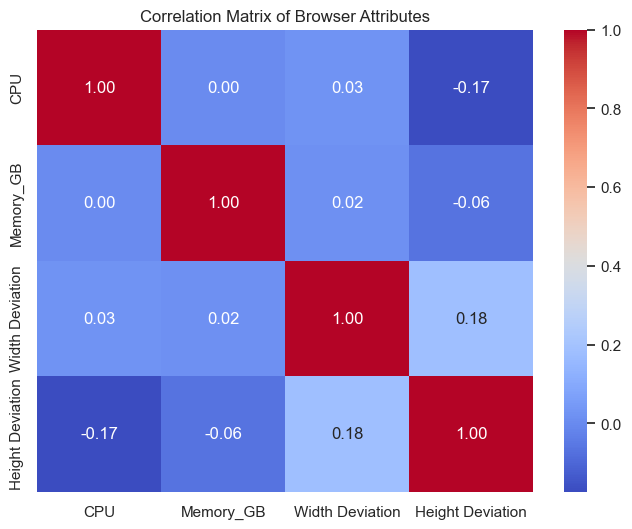

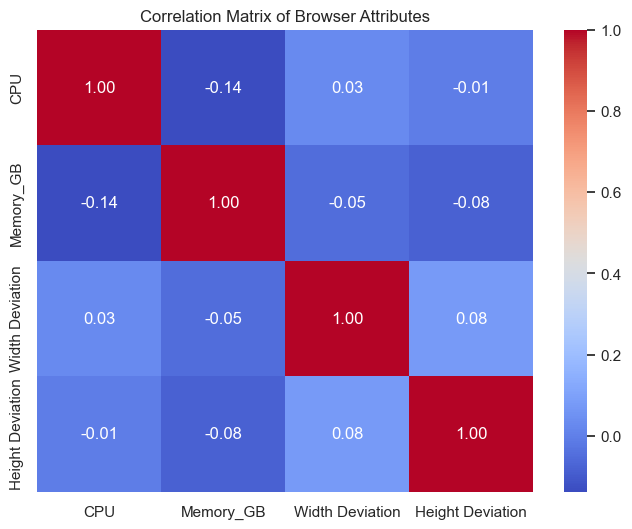

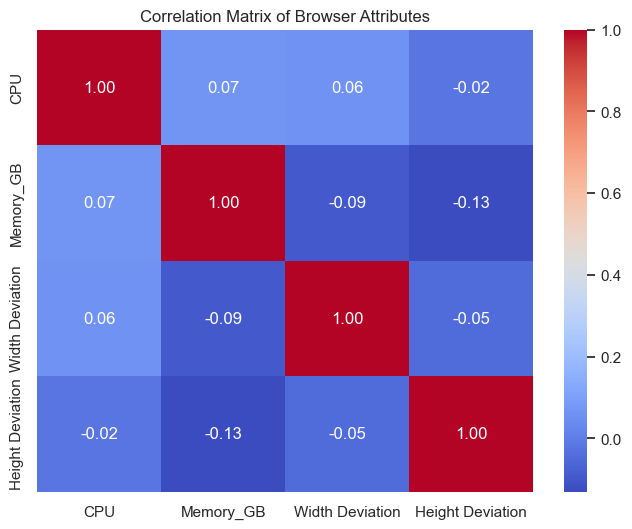

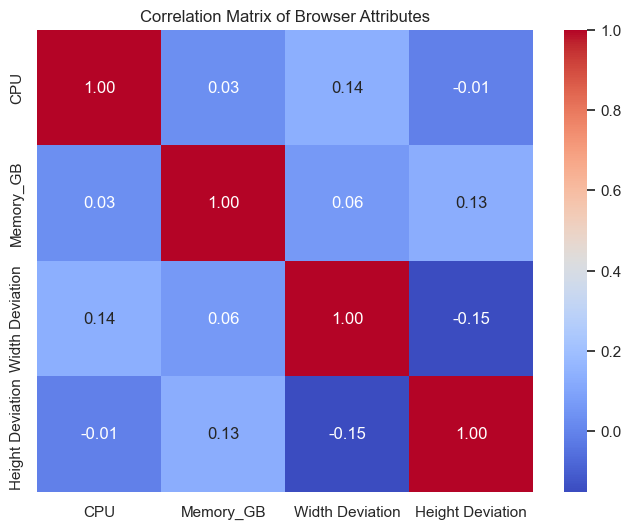

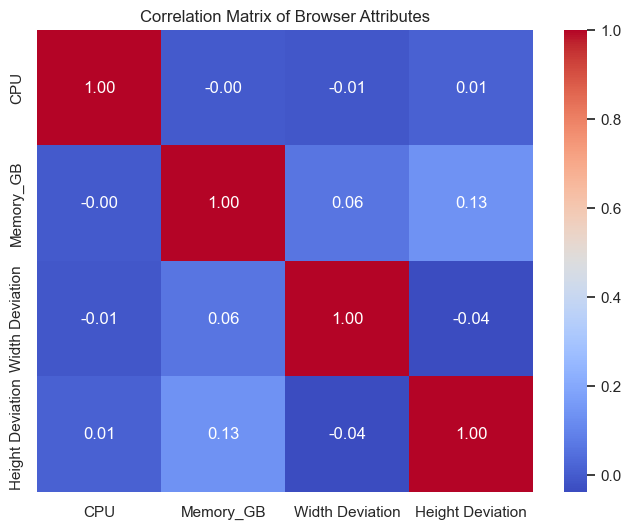

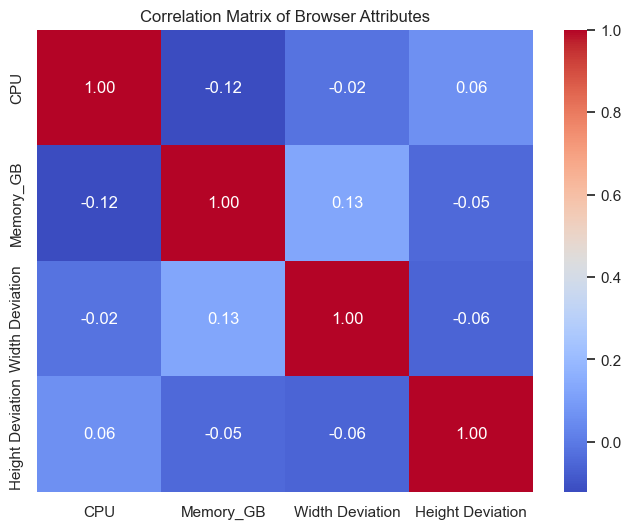

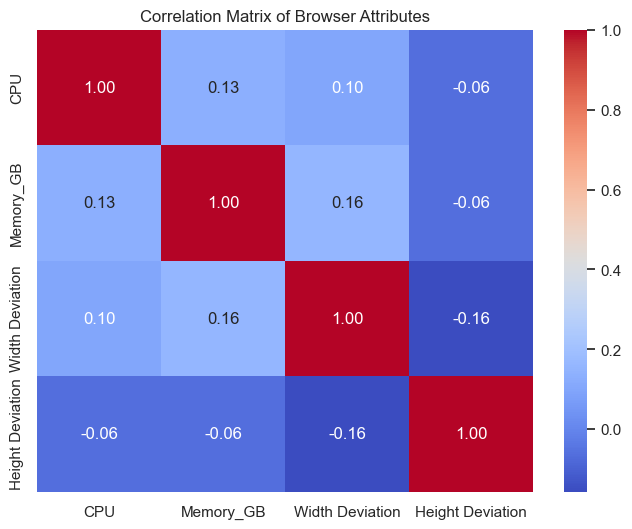

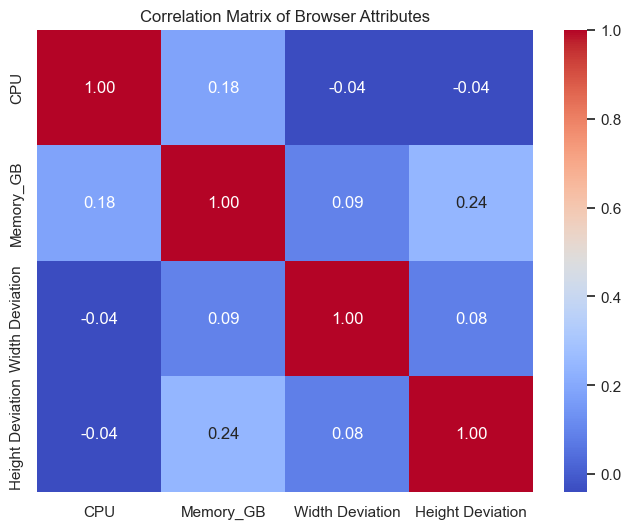

In [15]:
create_correlation_matrix4(pc_a_win10_strict_A)
create_correlation_matrix4(pc_a_win10_strict_B)
create_correlation_matrix4(pc_a_win10_classic_A)
create_correlation_matrix4(pc_a_win10_classic_B)
create_correlation_matrix4(pc_b_win11_strict_A)
create_correlation_matrix4(pc_b_win11_strict_B)
create_correlation_matrix4(pc_b_win11_classic_A)
create_correlation_matrix4(pc_b_win11_classic_B)



# Analysis of CPU cores

In [16]:
cpu_stats = get_stats('CPU')

print("CPU")
print(cpu_stats)

CPU
                                       mean  median  range  var  max  min  std
PC A Win10 Brave Aggressive Profile A  5.16    5.00   6.00 3.97 8.00 2.00 1.99
PC A Win10 Brave Aggressive Profile B  5.06    5.00   6.00 3.94 8.00 2.00 1.98
PC A Win10 Brave Classic Profile A     3.02    3.00   2.00 0.69 4.00 2.00 0.83
PC A Win10 Brave Classic Profile B     2.93    3.00   2.00 0.75 4.00 2.00 0.87
PC B Win11 Brave Aggressive Profile A  5.03    5.00   6.00 4.27 8.00 2.00 2.07
PC B Win11 Brave Aggressive Profile B  4.96    5.00   6.00 4.19 8.00 2.00 2.05
PC B Win11 Brave Classic A             4.89    5.00   6.00 3.75 8.00 2.00 1.94
PC B Win11 Brave Classic B             5.00    5.00   6.00 3.61 8.00 2.00 1.90


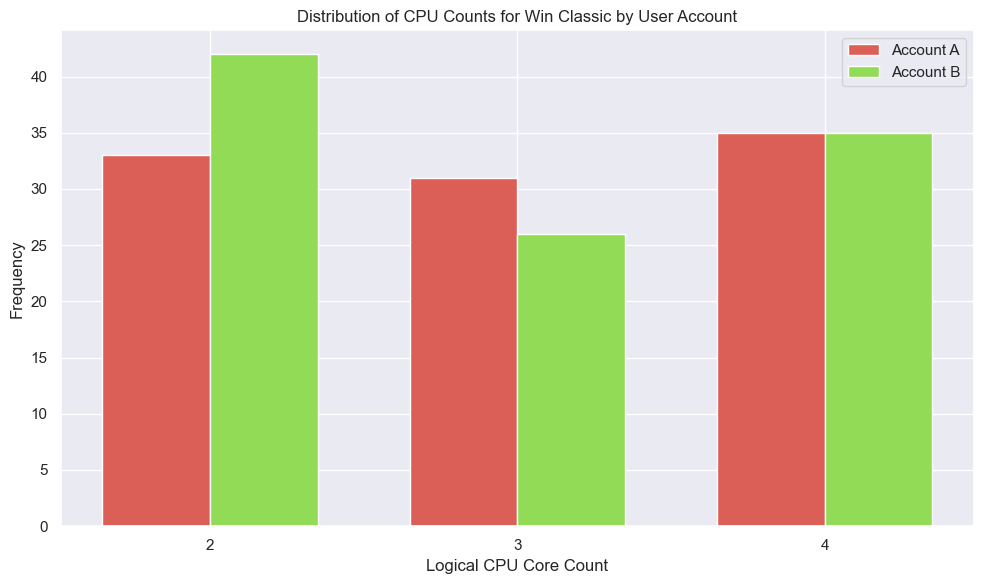

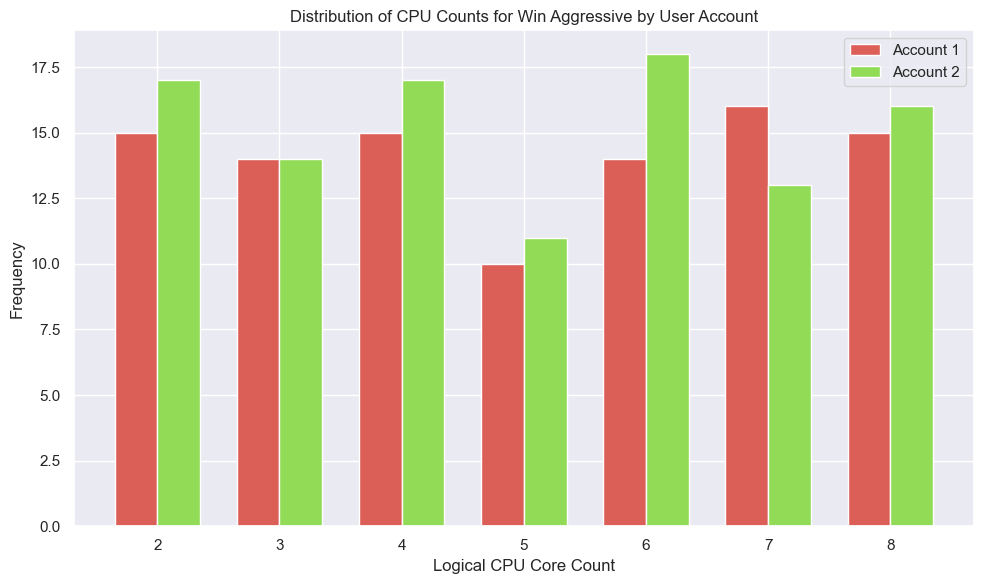

In [17]:
create_distribution_plot(pc_a_win10_classic_A, pc_a_win10_classic_B, 'Account A', 'Account B', 'Distribution of CPU Counts for Win Classic by User Account', 'Logical CPU Core Count', 'Frequency', 'CPU')
create_distribution_plot(pc_b_win11_strict_A, pc_b_win11_strict_B, 'Account 1', 'Account 2', 'Distribution of CPU Counts for Win Strict by User Account', 'Logical CPU Core Count', 'Frequency', 'CPU')

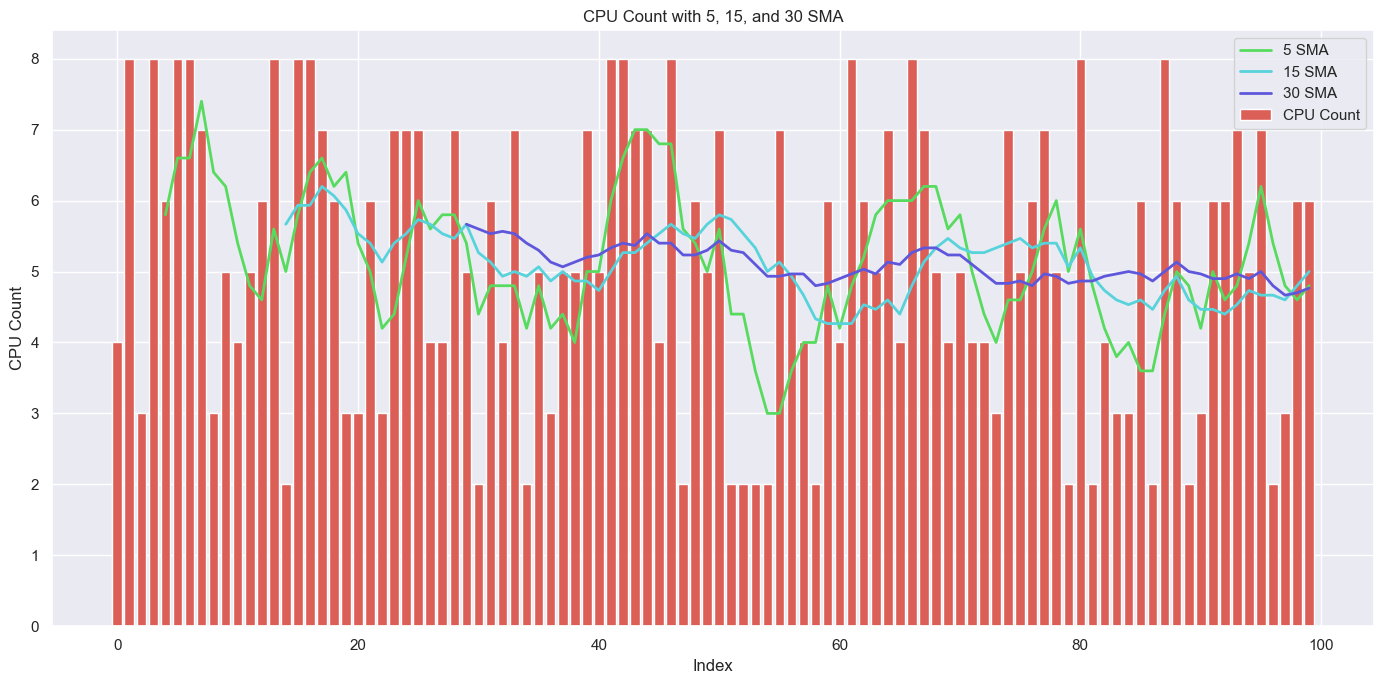

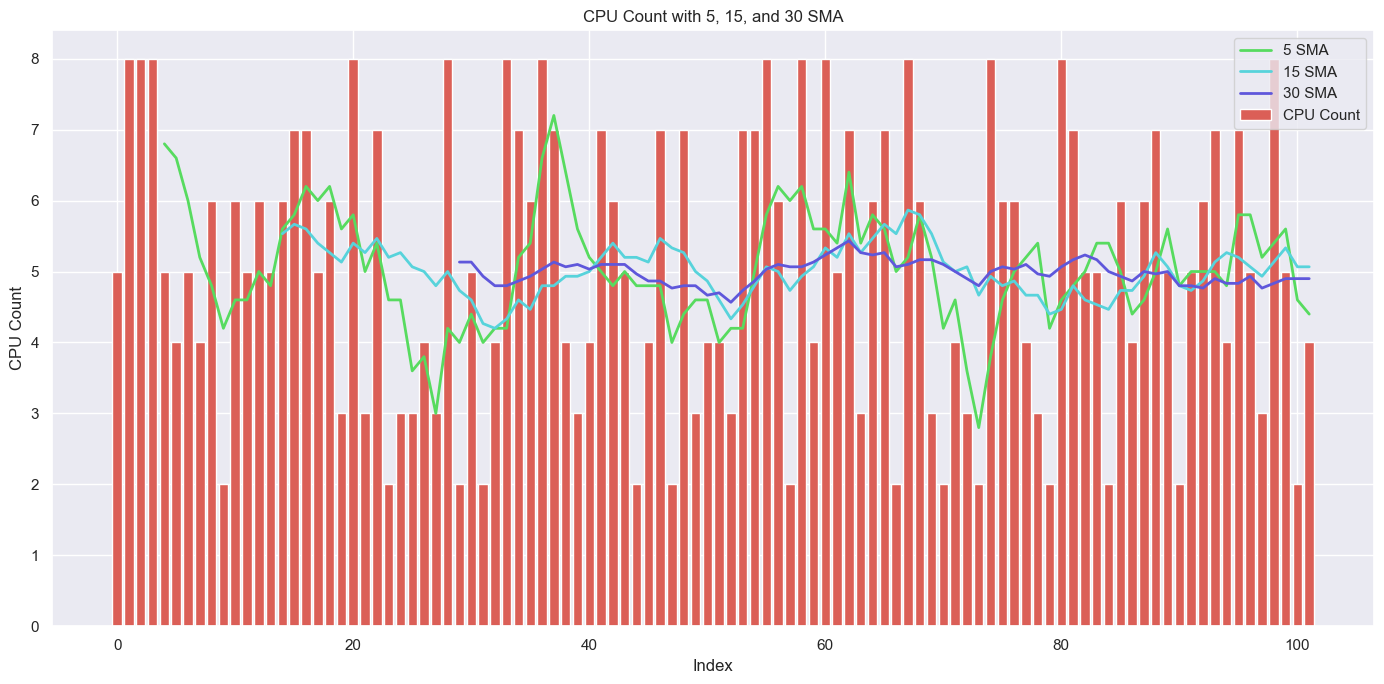

In [18]:
create_sma_bar_plot(pc_a_win10_strict_A, 'CPU', 'CPU Count with 5, 15, and 30 SMA', 'Index', 'CPU Count')
create_sma_bar_plot(pc_a_win10_strict_B, 'CPU', 'CPU Count with 5, 15, and 30 SMA', 'Index', 'CPU Count')

# Memory analysis

In [19]:
mem_stats = get_stats('Memory_GB')
print(mem_stats)

                                       mean  median  range  var  max  min  std
PC A Win10 Brave Aggressive Profile A  3.03    2.00   7.75 8.03 8.00 0.25 2.83
PC A Win10 Brave Aggressive Profile B  2.54    1.00   7.75 8.09 8.00 0.25 2.84
PC A Win10 Brave Classic Profile A     3.19    2.00   7.50 7.93 8.00 0.50 2.82
PC A Win10 Brave Classic Profile B     3.55    2.00   7.50 8.58 8.00 0.50 2.93
PC B Win11 Brave Aggressive Profile A  2.53    1.00   7.75 7.33 8.00 0.25 2.71
PC B Win11 Brave Aggressive Profile B  2.74    2.00   7.75 7.57 8.00 0.25 2.75
PC B Win11 Brave Classic A             2.83    2.00   7.50 6.70 8.00 0.50 2.59
PC B Win11 Brave Classic B             3.60    2.00   7.50 8.60 8.00 0.50 2.93


In [20]:
create_freq_table("Memory_GB")

,PC A Win10 Brave Aggressive Profile A,PC A Win10 Brave Aggressive Profile B,PC A Win10 Brave Classic Profile A,PC A Win10 Brave Classic Profile B,PC B Win11 Brave Aggressive Profile A,PC B Win11 Brave Aggressive Profile B,PC B Win11 Brave Classic Profile A,PC B Win11 Brave Classic Profile B
Memory_GB,,,,,,,,
0.25,15,26,0,0,16,18,0,0
0.50,16,21,19,21,20,10,21,8
1.00,11,8,18,15,16,23,14,9
2.00,16,13,24,18,16,19,34,11
4.00,22,16,16,22,15,17,13,10
8.00,20,18,22,27,16,19,17,14


# Deviation Analysis

In [21]:
create_freq_table("Width Deviation")

,PC A Win10 Brave Aggressive Profile A,PC A Win10 Brave Aggressive Profile B,PC A Win10 Brave Classic Profile A,PC A Win10 Brave Classic Profile B,PC B Win11 Brave Aggressive Profile A,PC B Win11 Brave Aggressive Profile B,PC B Win11 Brave Classic Profile A,PC B Win11 Brave Classic Profile B
Width Deviation,,,,,,,,
0,12,16,10,10,10,10,7,5
1,12,9,13,15,8,13,19,7
2,16,8,10,8,11,12,6,4
3,12,11,10,12,15,6,15,5
4,5,13,11,11,12,9,7,6
5,10,6,11,10,13,15,11,5
6,12,11,11,13,12,20,10,5
7,12,14,13,10,5,11,11,10
8,9,14,10,14,13,10,13,5


In [22]:
create_freq_table("Height Deviation")

,PC A Win10 Brave Aggressive Profile A,PC A Win10 Brave Aggressive Profile B,PC A Win10 Brave Classic Profile A,PC A Win10 Brave Classic Profile B,PC B Win11 Brave Aggressive Profile A,PC B Win11 Brave Aggressive Profile B,PC B Win11 Brave Classic Profile A,PC B Win11 Brave Classic Profile B
Height Deviation,,,,,,,,
0,8,19,9,13,12,10,13,3
1,11,14,15,15,20,17,6,9
2,8,14,13,14,9,15,11,11
3,7,14,9,12,8,11,12,7
4,17,14,10,18,5,10,5,5
5,12,14,11,20,13,10,11,2
6,18,12,8,10,11,17,14,6
7,8,1,15,1,13,9,10,7
8,11,0,9,0,8,7,17,2


In [23]:
width_stats = get_stats('Width Deviation')
print(width_stats)

                                       mean  median  range  var  max  min  std
PC A Win10 Brave Aggressive Profile A  3.78    3.00   8.00 6.88 8.00 0.00 2.62
PC A Win10 Brave Aggressive Profile B  4.08    4.00   8.00 7.72 8.00 0.00 2.78
PC A Win10 Brave Classic Profile A     4.03    4.00   8.00 6.72 8.00 0.00 2.59
PC A Win10 Brave Classic Profile B     4.09    4.00   8.00 7.00 8.00 0.00 2.65
PC B Win11 Brave Aggressive Profile A  4.03    4.00   8.00 6.17 8.00 0.00 2.48
PC B Win11 Brave Aggressive Profile B  4.18    5.00   8.00 6.49 8.00 0.00 2.55
PC B Win11 Brave Classic A             4.04    4.00   8.00 6.94 8.00 0.00 2.63
PC B Win11 Brave Classic B             4.21    4.00   8.00 6.99 8.00 0.00 2.64


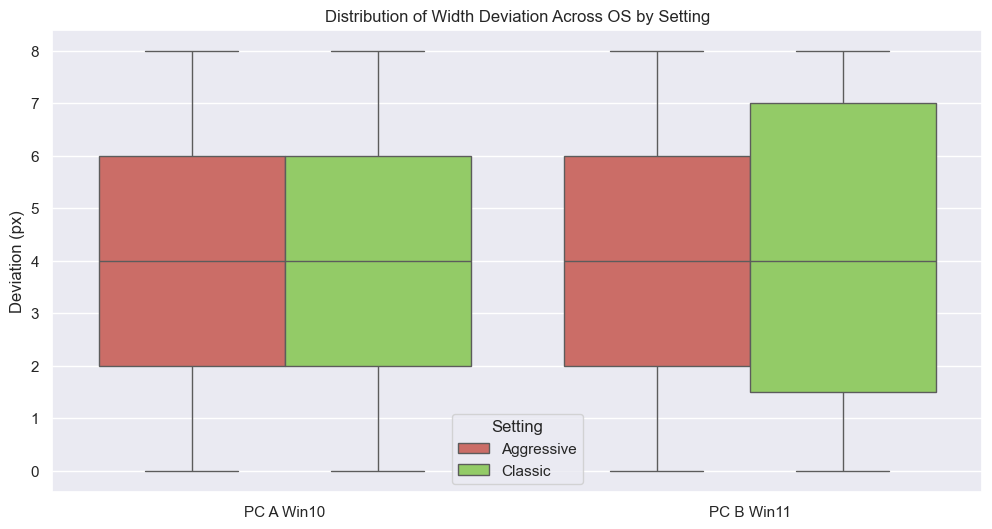

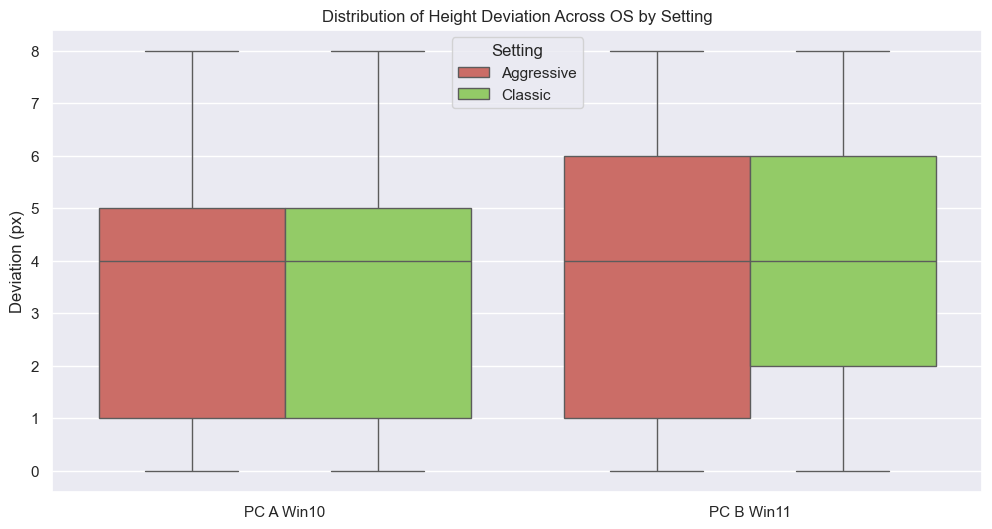

In [24]:
create_comparing_boxplot('Width Deviation', 'Distribution of Width Deviation Across OS by Setting', '', 'Deviation (px)')
create_comparing_boxplot('Height Deviation', 'Distribution of Height Deviation Across OS by Setting', '', 'Deviation (px)')

# Plugins analysis


In [25]:
plugins_df = pd.concat(
    [df[['Plugins']].assign(Source=key) for key, df in dataframes.items()],
    ignore_index=True
)

plugins_df['Plugins_Dict'] = plugins_df['Plugins'].apply(safe_string_to_dict)

In [26]:
unique_words = [
    "Brave",
    "Browser",
    "Chrome",
    "Chromium",
    "Display",
    "Document",
    "Format",
    "internal",
    "Microsoft",
    "Edge",
    "WebKit",
    "built-in",
    "JavaScript",
    "Online",
    "OpenSource",
    "PDF",
    "PS",
    "Plugin",
    "Portable",
    "Renderer",
    "Viewer",
    "Web",
    "and",
    "com.adobe.pdf",
    "doc",
    "document",
    "extension",
    "plug",
    "plug-in",
    "portable",
    "document",
    "format",
]

def find_known_plugins(dict):
    normal_words = 0
    for key, value in dict.items():
        for word in unique_words:
            if len(word) < 4:
                continue
            if word.lower() in key.lower():
                normal_words = normal_words + 1
                break
            elif word.lower() in value.lower():
                normal_words = normal_words + 1
                break
    return [normal_words, len(dict)-normal_words]

plugins_df['Plugins count'] = plugins_df['Plugins_Dict'].apply(find_known_plugins)

<Figure size 1400x800 with 0 Axes>

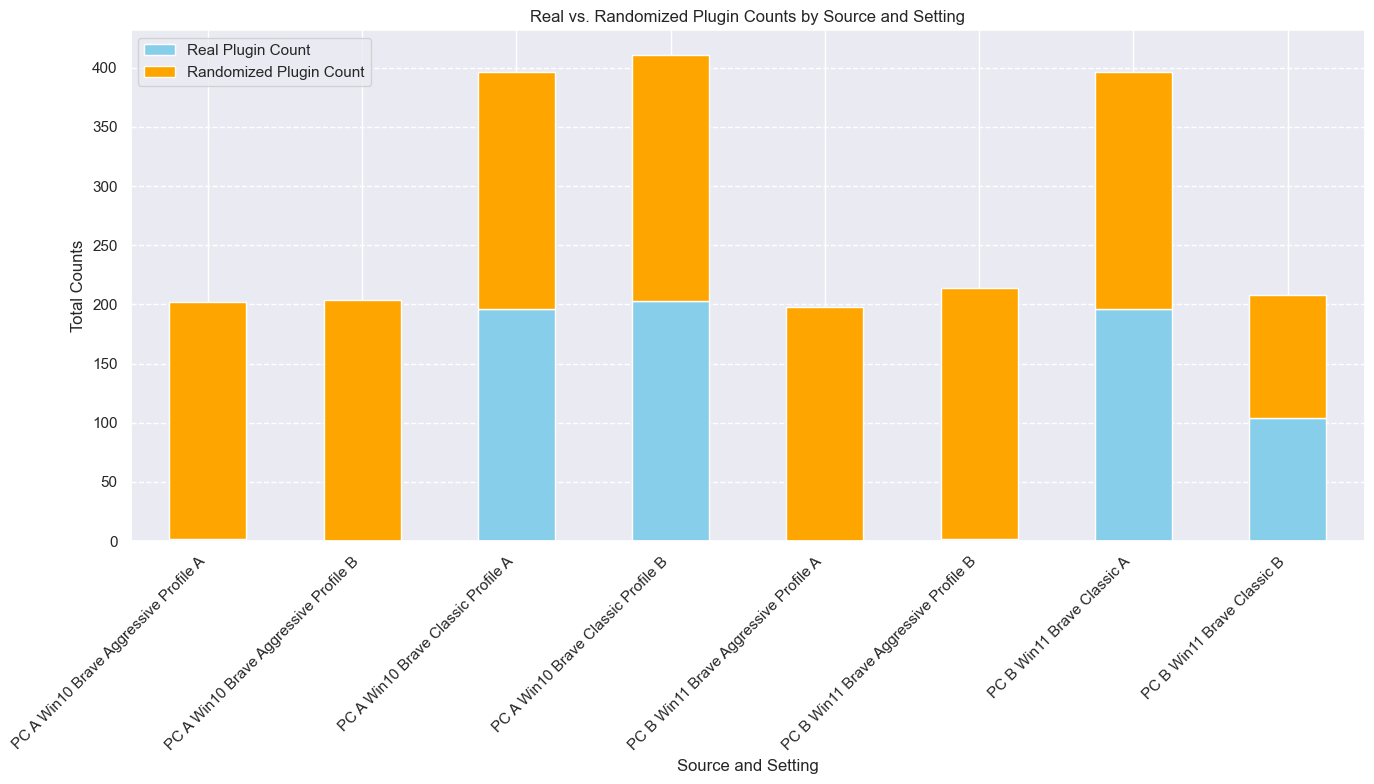

In [27]:
plugins_df[['Real Plugin Count', 'Randomized Plugin Count']] = pd.DataFrame(plugins_df['Plugins count'].tolist(), index=plugins_df.index)
source = plugins_df.groupby('Source')[['Real Plugin Count', 'Randomized Plugin Count']].sum()


plt.figure(figsize=(14, 8))
source.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(14, 8))

plt.title('Real vs. Randomized Plugin Counts by Source and Setting')
plt.ylabel('Total Counts')
plt.xlabel('Source and Setting')
plt.xticks(rotation=45, ha="right")
plt.legend(['Real Plugin Count', 'Randomized Plugin Count'])
plt.grid(axis='y', linestyle='--')

plt.tight_layout()

In [28]:
# Extract device type and setting from the 'Source' column if not already done
plugins_df['Device Type'] = plugins_df['Source'].str.extract('(Win|WinNB|Win2|WinNB2)')
plugins_df['Setting'] = plugins_df['Source'].apply(lambda x: 'Strict' if 'Strict' in x else 'Classic')

# Group by 'Device Type' and 'Setting' to calculate average real and randomized plugin counts
average_counts_per_device_setting = plugins_df.groupby(['Source'])[['Real Plugin Count', 'Randomized Plugin Count']].mean().reset_index()

average_counts_per_device_setting

,Source,Real Plugin Count,Randomized Plugin Count
0,PC A Win10 Brave Aggressive Profile A,0.02,2.00
1,PC A Win10 Brave Aggressive Profile B,0.00,2.00
2,PC A Win10 Brave Classic Profile A,1.98,2.02
3,PC A Win10 Brave Classic Profile B,1.97,2.02
4,PC B Win11 Brave Aggressive Profile A,0.00,2.00
5,PC B Win11 Brave Aggressive Profile B,0.02,2.00
6,PC B Win11 Brave Classic A,1.98,2.02
7,PC B Win11 Brave Classic B,2.00,2.00


<Figure size 1400x800 with 0 Axes>

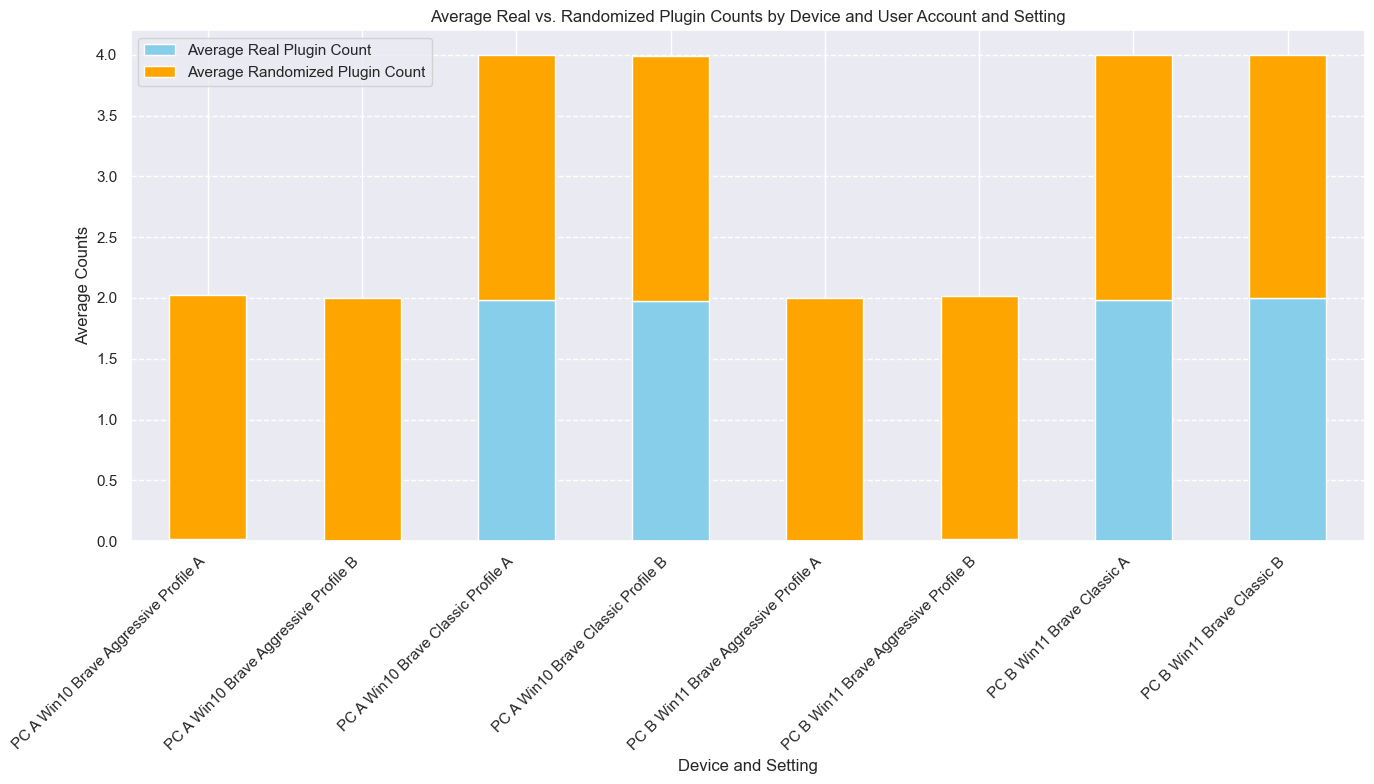

In [29]:
average_counts_per_device_setting.reset_index(inplace=True)

average_counts_for_plotting = average_counts_per_device_setting.set_index('Source')

plt.figure(figsize=(14, 8))
average_counts_for_plotting[['Real Plugin Count', 'Randomized Plugin Count']].plot(kind='bar', stacked=True, color=['skyblue', 'orange'], figsize=(14, 8))

plt.title('Average Real vs. Randomized Plugin Counts by Device and User Account and Setting')
plt.ylabel('Average Counts')
plt.xlabel('Device and Setting')
plt.xticks(rotation=45, ha="right")
plt.legend(['Average Real Plugin Count', 'Average Randomized Plugin Count'])
plt.grid(axis='y', linestyle='--')

plt.tight_layout()

plt.show()

# Cross-profile Correlation

In [ ]:
# PC A Win10 Aggressive Profile A vs Profile B
plot_cross_correlation(pc_a_win10_strict_A, pc_a_win10_strict_B, 'CPU', 'Profile A', 'Profile B')
plot_cross_correlation(pc_a_win10_strict_A, pc_a_win10_strict_B, 'Memory_GB', 'Profile A', 'Profile B')
plot_cross_correlation(pc_a_win10_strict_A, pc_a_win10_strict_B, 'Width Deviation', 'Profile A', 'Profile B')
plot_cross_correlation(pc_a_win10_strict_A, pc_a_win10_strict_B, 'Height Deviation', 'Profile A', 'Profile B')

# PC A Win10 Classic Profile A vs Profile B
plot_cross_correlation(pc_a_win10_classic_A, pc_a_win10_classic_B, 'CPU', 'Profile A', 'Profile B')
plot_cross_correlation(pc_a_win10_classic_A, pc_a_win10_classic_B, 'Memory_GB', 'Profile A', 'Profile B')
plot_cross_correlation(pc_a_win10_classic_A, pc_a_win10_classic_B, 'Width Deviation', 'Profile A', 'Profile B')
plot_cross_correlation(pc_a_win10_classic_A, pc_a_win10_classic_B, 'Height Deviation', 'Profile A', 'Profile B')

# PC B Win11 Aggressive Profile A vs Profile B
plot_cross_correlation(pc_b_win11_strict_A, pc_b_win11_strict_B, 'CPU', 'Profile A', 'Profile B')
plot_cross_correlation(pc_b_win11_strict_A, pc_b_win11_strict_B, 'Memory_GB', 'Profile A', 'Profile B')
plot_cross_correlation(pc_b_win11_strict_A, pc_b_win11_strict_B, 'Width Deviation', 'Profile A', 'Profile B')
plot_cross_correlation(pc_b_win11_strict_A, pc_b_win11_strict_B, 'Height Deviation', 'Profile A', 'Profile B')

# PC B Win11 Classic Profile A vs Profile B
plot_cross_correlation(pc_b_win11_classic_A, pc_b_win11_classic_B, 'CPU', 'Profile A', 'Profile B')
plot_cross_correlation(pc_b_win11_classic_A, pc_b_win11_classic_B, 'Memory_GB', 'Profile A', 'Profile B')
plot_cross_correlation(pc_b_win11_classic_A, pc_b_win11_classic_B, 'Width Deviation', 'Profile A', 'Profile B')
plot_cross_correlation(pc_b_win11_classic_A, pc_b_win11_classic_B, 'Height Deviation', 'Profile A', 'Profile B')